In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import sim_framework as sf 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


# When downstream phenotype captures mostly genetic effects 

Simulate biomarkers with a particular level of heritability

In [2]:
N, n, m, k = 1000, 100, 1, 0
n_B, n_P, n_BP = 50, 0, 0
p = 0.25
sigma_B, sigma_P, sigma_BP = 1, 1, 1
sigma_epsilon_B, sigma_epsilon_P = 0.001, 1
results = sf.simulate_phenotypes_and_biomarkers_with_correlations(N, n, m, k, n_B, n_P, n_BP, p,
                                                                  sigma_B, sigma_P, sigma_BP,
                                                                  sigma_epsilon_B, sigma_epsilon_P)

B, _, h2_B, _, _, _, _, G, causal_indices_B, _, E_B, _, evn_B,_  = results

Generate downstream (ML) phenos with different levels of phenotypic correlation with biomarkers and perform GWAS

In [4]:
correlations = np.arange(0.1,0.99,0.01)
env_variance = np.array([0.01]) 
TPR_rec = []
FPR_rec = []
rg_rec = []
correlations_act = []

for i in range(len(correlations)):
    correlation_matrix = np.array([[correlations[i]]])
    B = (B - np.mean(B))/np.std(B)
    P = sf.simulate_downstream_phenotypes(B, correlation_matrix, env_variance)
    results = sf.run_gwas_return_metrics(P, G, causal_indices_B.T, E_B.T)
    _, _, TPR, FPR, Effect_correlation,_ = results 
    TPR_rec += [TPR]
    FPR_rec += [FPR]
    correlations_act += [np.corrcoef(B.flatten(),P.flatten())[0,1]**2]
    rg_rec += [Effect_correlation]

Text(0.5, 1.0, 'Mostly genetic effects')

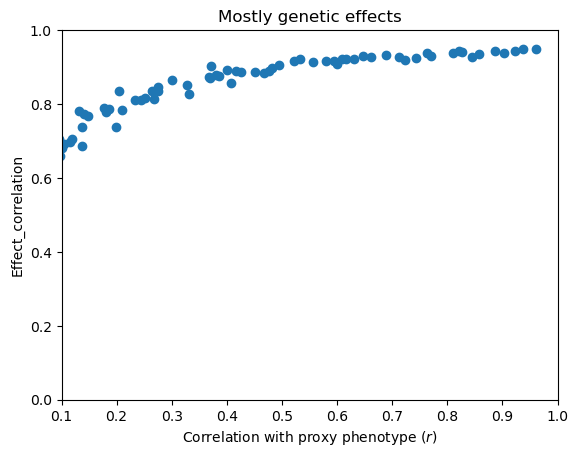

In [5]:
plt.scatter(correlations_act, rg_rec)
plt.xlim([0.1,1.0])
plt.ylim([0.,1.0])
plt.xlabel('Correlation with proxy phenotype ($r$)')
plt.ylabel('Effect_correlation')
plt.title('Mostly genetic effects')

# When downstream phenotype captures mostly environmental effects

In [39]:
N, n, m, k = 50000, 100, 1, 0
n_B, n_P, n_BP = 50, 0, 0
p = 0.25
sigma_B, sigma_P, sigma_BP = 1, 1, 1
sigma_epsilon_B, sigma_epsilon_P = 1000, 1
results = sf.simulate_phenotypes_and_biomarkers_with_correlations(N, n, m, k, n_B, n_P, n_BP, p,
                                                                  sigma_B, sigma_P, sigma_BP,
                                                                  sigma_epsilon_B, sigma_epsilon_P)

B, _, h2_B2, _, _, _, _, G, causal_indices_B, _, E_B, _, env_B, _  = results

In [40]:
correlations = np.arange(0.01,0.99,0.01)
env_variance = np.array([0.01]) 
TPR_rec = []
FPR_rec = []
rg_rec2 = []
correlations_act2 = []

for i in range(len(correlations)):
    correlation_matrix = np.array([[correlations[i]]])
    B = (B - np.mean(B))/np.std(B)
    P = sf.simulate_downstream_phenotypes(env_B, correlation_matrix, env_variance)
    results = sf.run_gwas_return_metrics(P, G, causal_indices_B.T, E_B.T)
    correlations_act2 += [np.corrcoef(B.flatten(),P.flatten())[0,1]**2]
    _, _, TPR, FPR, Effect_correlation,_ = results 
    TPR_rec += [TPR]
    FPR_rec += [FPR]
    rg_rec2 += [Effect_correlation]

Text(0.5, 1.0, 'Mostly environmental effects')

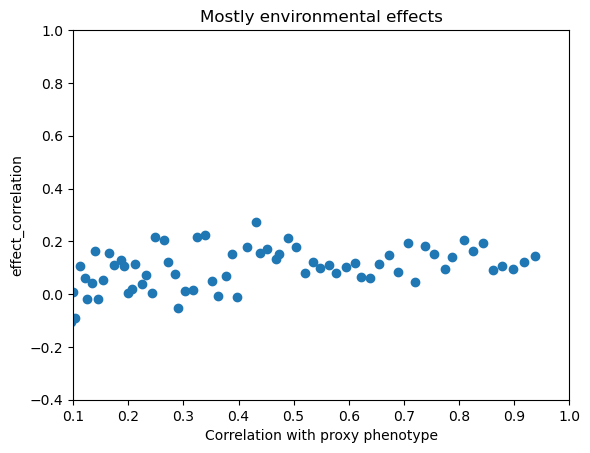

In [41]:
plt.scatter(correlations_act2, rg_rec2)
plt.xlim([0.1,1.0])
plt.ylim([-.4,1.0])
plt.xlabel('Correlation with proxy phenotype')
plt.ylabel('effect_correlation')
plt.title('Mostly environmental effects')

# Plot together

/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ec2-user/miniconda3/envs/insitro/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


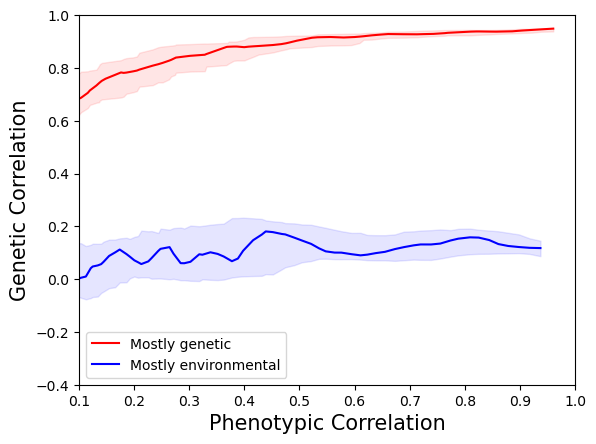

In [42]:
# Make sure the data arrays are indeed one-dimensional
#correlations_act = np.ravel(correlations_act)
#rg_rec = np.ravel(rg_rec)

#correlations_act2 = np.ravel(correlations_act2)
#rg_rec2 = np.ravel(rg_rec2)


# Creating pandas DataFrame for Seaborn
data1 = pd.DataFrame({'Phenotypic Correlation': correlations_act, 'Effect Size Correlation': rg_rec})
data2 = pd.DataFrame({'Phenotypic Correlation': correlations_act2, 'Effect Size Correlation': rg_rec2})

# Function to calculate LOWESS and confidence interval
def lowess_with_confidence(x, y, frac=0.1, it=0):
    # Calculate LOWESS smoothed line
    lowess = sm.nonparametric.lowess(y, x, frac=frac, it=it, return_sorted=True)
    prediction = lowess[:, 1]
    x_pred = lowess[:, 0]
    
    # Bootstrapping for confidence intervals
    num_boot = 500
    boot_samples = np.random.choice(range(len(x)), replace=True, size=(num_boot, len(x)))
    boot_lowess = np.array([sm.nonparametric.lowess(y[bsample], x[bsample], frac=frac, it=it, return_sorted=True)[:, 1] for bsample in boot_samples])
    
    # Getting the 2.5th and 97.5th percentile to form the 95% confidence interval
    ci_lower = np.percentile(boot_lowess, 2.5, axis=0)
    ci_upper = np.percentile(boot_lowess, 97.5, axis=0)
    
    return x_pred, prediction, ci_lower, ci_upper

# Calculate LOWESS and CI for the first dataset
x1_lowess, y1_lowess, y1_ci_lower, y1_ci_upper = lowess_with_confidence(data1['Phenotypic Correlation'], data1['Effect Size Correlation'])

# Plot LOWESS smoothed line for the first dataset
plt.plot(x1_lowess, y1_lowess, color='r', label='Mostly genetic')

# Plot CI as a fill between for the first dataset
plt.fill_between(x1_lowess, y1_ci_lower, y1_ci_upper, color='r', alpha=0.1)

# Calculate LOWESS and CI for the second dataset
x2_lowess, y2_lowess, y2_ci_lower, y2_ci_upper = lowess_with_confidence(data2['Phenotypic Correlation'], data2['Effect Size Correlation'])

# Plot LOWESS smoothed line for the second dataset
plt.plot(x2_lowess, y2_lowess, color='b',label='Mostly environmental')

# Plot CI as a fill between for the second dataset
plt.fill_between(x2_lowess, y2_ci_lower, y2_ci_upper, color='b', alpha=0.1)

# Set plot limits
plt.xlim([0.1, 1.0])
plt.ylim([-0.4, 1.0])

# Axes labels
plt.xlabel('Phenotypic Correlation', fontsize=15)
plt.ylabel('Genetic Correlation', fontsize=15)

# Legend
plt.legend()

# Display plot
plt.show()
